### Roll-out metrics notebook

In [1]:
import torch
import random
import pandas as pd
import torch_scatter
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import time
import torch.optim as optim
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns


import os
import numpy as np
import torch
import functools
import json
from torch_geometric.data import Data
import enum
from scipy.spatial import Delaunay
#NEAREST NEUGHBOURS interpolatior
from scipy.interpolate import NearestNDInterpolator
import cmocean.cm as cm



import sys
sys.path.append('../src')
from ice_graph.ice_graph import Ice_graph
from utils.graph_utils import compute_stats_batch,normalize_data,normalize,unnormalize
from models.MGN import MeshGraphNet
from models.GUnet import GUNet



In [2]:
def triangles_to_edges(faces):
    """Computes mesh edges from triangles."""
    # collect edges from triangles
    faces = torch.tensor(faces)
    edges = torch.cat((faces[:, 0:2],
                       faces[:, 1:3],
                       torch.stack((faces[:, 2], faces[:, 0]), dim=1)), dim=0)
    
    # those edges are sometimes duplicated (within the mesh) and sometimes
    # single (at the mesh boundary).
    # sort & pack edges as single torch.int64
    receivers = torch.min(edges, dim=1)[0]
    senders = torch.max(edges, dim=1)[0]
    packed_edges = torch.stack((senders, receivers), dim=1).to(torch.int64)
    # remove duplicates and unpack
    unique_edges = torch.unique(packed_edges, dim=0)
    senders, receivers = unique_edges.unbind(1)
    
    # create two-way connectivity
    return torch.stack([torch.cat((senders, receivers), dim=0),
            torch.cat((receivers, senders), dim=0)])


In [3]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

for args in [
        {'model_type': 'meshgraphnet',
         'num_layers': 6,
         'batch_size': 8,
         'hidden_dim': 32,
         'epochs': 50,
         'opt': 'adam',
         'opt_scheduler': 'cos',
         'opt_restart': 0,
         'weight_decay': 5e-4,
         'lr': 0.001,
         'train_size': 40,
         'test_size': 2,
         'device':'cpu',
         'shuffle': True,
         'save_velo_val': False,
         'save_best_model': True,
         'checkpoint_dir': './best_models/',
         'postprocess_dir': './2d_loss_plots/'},
    ]:
        args = objectview(args)

#To ensure reproducibility the best we can, here we control the sources of
#randomness by seeding the various random number generators used in this Colab
#For more information, see: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(5)  #Torch
random.seed(5)        #Python
np.random.seed(5)     #NumPy

In [10]:
!ls ../best_models/roll_out_models/

crop_vel_3h_survived_f_meshgraphnet_deformation_loss_5e-16_plateau_nl10_bs8_hd18_ep120_wd1e-05_lr0.00062_shuff_True_tr250_te20_accFalse_rollout.pt
crop_vel_3h_survived_f_meshgraphnet_mse_5e-14_plateau_nl6_bs4_hd32_ep60_wd1e-05_lr0.00062_shuff_True_tr250_te20_accFalse_rollout.pt
vel_3h_survived_f_meshgraphnet_mse_0_plateau_nl8_bs8_hd10_ep120_wd1e-05_lr0.00062_shuff_True_tr250_te20_rollout2.pt
vel_3h_survived_f_meshgraphnet_mse_0_plateau_nl8_bs8_hd10_ep120_wd1e-05_lr0.00062_shuff_True_tr250_te20_rollout.pt


In [4]:
# load model.
#load graphs one by one
file_path = '../data_graphs/crop_vel_3h_survived_f'
#get file names sorted in order
graph_files = [i for i in os.listdir(file_path) if "list" not in i and "pt" in i]
graph_files = sorted(graph_files,key=lambda x:int(x.split("_")[-1].split(".")[0]) if x.split("_")[-1].split(".")[0].isdigit() else 0)[:]
graph_list = []
for file in tqdm(graph_files):
    with open(os.path.join(file_path,file),'rb') as f:
            graph_list.append(torch.load(f))
            
graph_list[0], len(graph_list)

stats_list = compute_stats_batch(graph_list)
dataset = copy.deepcopy(graph_list[-50:])
del graph_list

model_name = "crop_vel_3h_survived_f_meshgraphnet_mse_5e-14_plateau_nl6_bs4_hd32_ep60_wd1e-05_lr0.00062_shuff_True_tr250_te20_accFalse_rollout"
args.device = torch.device('cpu') # 
num_node_features = dataset[0].x.shape[1]
num_edge_features = dataset[0].edge_attr.shape[1]
num_classes = 2 # the dynamic variables have the shape of 2 (velocity)
PATH = f"../best_models/roll_out_models/{model_name}.pt"#os.path.join( checkpoint_dir, f'{model_name}.pt')

if args.model_type == 'meshgraphnet':
        model = MeshGraphNet(num_node_features, num_edge_features, args.hidden_dim, num_classes,
                            args)
if args.model_type == 'gunet':
    model = GUNet(num_node_features, num_classes)

model.load_state_dict(torch.load(PATH, map_location=args.device))
normalized = True

100%|██████████| 275/275 [00:00<00:00, 419.70it/s]


In [5]:
def get_interpolators(data):
    x,y = data.mesh_pos[:,0],data.mesh_pos[:,1]
    features = data.x.cpu().numpy()
    interp = {}
    interp['u_wind'] = NearestNDInterpolator((x, y), features[:,2])
    interp['v_wind'] = NearestNDInterpolator((x, y), features[:,3])
    interp['u_ocean'] = NearestNDInterpolator((x, y), features[:,4])
    interp['v_ocean'] = NearestNDInterpolator((x, y), features[:,5])
    interp['u_wind1'] = NearestNDInterpolator((x, y), features[:,8])
    interp['v_wind1'] = NearestNDInterpolator((x, y), features[:,9])
    interp['u_ocean1'] = NearestNDInterpolator((x, y), features[:,10])
    interp['v_ocean1'] = NearestNDInterpolator((x, y), features[:,11])

    return interp


def jacobian(x0, y0, x1, y1, x2, y2):
    return (x1-x0)*(y2-y0)-(x2-x0)*(y1-y0)


def compute_div(p0,p1, lower_threshold, upper_threshold):
    x0,y0 = p0[:,0].cpu().numpy(),p0[:,1].cpu().numpy()
    x1,y1 = p1[:,0].cpu().numpy(),p1[:,1].cpu().numpy()
    pos = np.stack([x1,y1],axis=1)
    t1 = Delaunay(pos,qhull_options='QJ').simplices
    # find starting / ending coordinates for each elements
    x0a, x0b, x0c = x0[t1].T
    y0a, y0b, y0c = y0[t1].T
    xpa, xpb, xpc = x1[t1].T
    ypa, ypb, ypc = y1[t1].T

    # compute area at the first and second snapshots (subsampled mesh)
    a0 = jacobian(x0a, y0a, x0b, y0b, x0c, y0c)
    ap = jacobian(xpa, ypa, xpb, ypb, xpc, ypc)

    #divergence
    div_t = a0/ap

    #interpolate div into x,y grid
    x_mean = np.mean(x1[t1],axis=1)
    y_mean = np.mean(y1[t1],axis=1)
    div_interp = NearestNDInterpolator((x_mean, y_mean), div_t)
    div = div_interp(x1,y1)

    filtered_div = np.clip(np.where((div < lower_threshold) | (div > upper_threshold), div, 1),0.9,1.1)
    filtered_div_t = np.clip(np.where((div_t < lower_threshold) | (div_t > upper_threshold), div_t, 1),0.9,1.1)


    return filtered_div,filtered_div_t, t1


def rk4_step(data, model, dt):
    k1 = model(data).detach()
    data_k2 = copy.deepcopy(data)
    data_k2.mesh_pos = data.mesh_pos + 0.5 * k1 * dt
    k2 = model(data_k2).detach()
    
    data_k3 = copy.deepcopy(data)
    data_k3.mesh_pos = data.mesh_pos + 0.5 * k2 * dt
    k3 = model(data_k3).detach()
    
    data_k4 = copy.deepcopy(data)
    data_k4.mesh_pos = data.mesh_pos + k3 * dt
    k4 = model(data_k4).detach()
    
    return data.mesh_pos + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

def rk4_true_step(pos, target, dt):
    k1 = target
    k2 = target  # Assuming target does not change for intermediate steps
    k3 = target
    k4 = target
    
    return pos + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)



In [7]:
#both components
lead = 3

dt = 3600*lead
roll_out_set = copy.deepcopy(dataset[::int(dt/1800)])
[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y] = stats_list
data_1 = None
true_pos = None
data_0 = roll_out_set[0]
errors_position = []
plot = False #plot velocities true and pred
for i,graph in tqdm(enumerate(roll_out_set[:-1])):

    if data_1 is not None:
        graph = copy.deepcopy(data_1)
    
    else:
        mask = graph.x[:, -1] == 0
    
    data = normalize_data(graph,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y)
   
    pred = model(data)
    pred = unnormalize(pred,mean_vec_y,std_vec_y).detach()
    target = unnormalize(data.y,mean_vec_y,std_vec_y)
    data.x = unnormalize(data.x,mean_vec_x,std_vec_x)

    #inputs --> [dx01, dy01, wind_u, wind_v, ocean_u, ocean_v, concentration, thickness, wind_u1,wind_v1,ocean_u1,ocean_v1, node_type]
    #compute future positions
    mesh_pos = data.mesh_pos + pred * dt

    if true_pos is not None:
        true_pos = true_pos + target * dt
    else:
        pos_0 = data.mesh_pos
        true_pos = data.mesh_pos + target * dt

    bias_pos = mesh_pos - true_pos
    bias_norm  = np.sqrt(mesh_pos[:,0]**2 + mesh_pos[:,1]**2) - np.sqrt(true_pos[:,0]**2 + true_pos[:,1]**2)
    rmse_pos = torch.sqrt(torch.mean((mesh_pos - true_pos)[mask]**2,dim=0))
    errors_position.append(rmse_pos.numpy())

    features = torch.zeros_like(data.x)

    #update ocean and wind data.x[:,2:6] + data.x[:,8:12]
    interp = get_interpolators(copy.deepcopy(roll_out_set[i+1]))
    features[:,2] = torch.tensor(interp['u_wind'](mesh_pos[:,0],mesh_pos[:,1]))
    features[:,3] = torch.tensor(interp['v_wind'](mesh_pos[:,0],mesh_pos[:,1]))
    features[:,4] = torch.tensor(interp['u_ocean'](mesh_pos[:,0],mesh_pos[:,1]))
    features[:,5] = torch.tensor(interp['v_ocean'](mesh_pos[:,0],mesh_pos[:,1]))
    features[:,8] = torch.tensor(interp['u_wind1'](mesh_pos[:,0],mesh_pos[:,1]))
    features[:,9] = torch.tensor(interp['v_wind1'](mesh_pos[:,0],mesh_pos[:,1]))
    features[:,10] = torch.tensor(interp['u_ocean1'](mesh_pos[:,0],mesh_pos[:,1]))
    features[:,11] = torch.tensor(interp['v_ocean1'](mesh_pos[:,0],mesh_pos[:,1]))
    
    #update vel
    features[:,:2] = pred

    #get divergence div, t0 update
    div,div_t, t1 = compute_div(data.mesh_pos,mesh_pos,0.999 , 1.001)
    div_plot,div_t_plot, t1_plot = compute_div(pos_0,mesh_pos,0.999 , 1.001)
    true_div,true_div_t, true_t1 = compute_div(pos_0,true_pos,0.999 , 1.001)

    features[:,6] = torch.clip(data.x[:,6]*div,0,1)
    features[:,7] = data.x[:,7]*div
    features[:,-1] = features[:,-1]
    

    #triangulate t0
    edge_index = triangles_to_edges(t1).type(torch.long)

    u_i = torch.stack(
        (data.mesh_pos[:,0][edge_index[0]],
         data.mesh_pos[:,1][edge_index[0]]),
        dim=1
    )
    u_j = torch.stack(
        (data.mesh_pos[:,0][edge_index[1]],
         data.mesh_pos[:,1][edge_index[1]]),
        dim=1
    )

    u_ij = u_i - u_j
    u_ij_norm = torch.norm(u_ij, p=2, dim=1, keepdim=True)
    edge_attr = torch.cat((u_ij, u_ij_norm), dim=-1).type(torch.float)

    #interpolate next y values into out mesh
    data_true = roll_out_set[i+1]
    interp = NearestNDInterpolator((data_true.mesh_pos[:,0],data_true.mesh_pos[:,1]),data_true.y.cpu().numpy())
    y = torch.tensor(interp(mesh_pos[:,0],mesh_pos[:,1])).type(torch.float)
        
    
    data_1 = Data(x=features, edge_index=edge_index,edge_attr=edge_attr, mesh_pos = mesh_pos, y =y)


    #plot velocities true and pred
    if plot:

        #deformation errors
        fig, ax = plt.subplots(2, 2, figsize=(20, 15))

        im0 = ax[0,0].tripcolor(data.mesh_pos[:,0],data.mesh_pos[:,1],facecolors=div_t_plot,triangles=t1_plot,cmap=cm.curl, vmin=0.97, vmax=1.03)
        ax[0,0].set_xlabel("X coordinate (m)",fontsize=16)
        ax[0,0].set_ylabel("Y coordinate (m)",fontsize=16)
        plt.colorbar(im0,ax=ax[0,0]).set_label("Area ratio",fontsize=16)

        im1 = ax[0,1].tripcolor(data.mesh_pos[:,0],data.mesh_pos[:,1],facecolors=true_div_t,triangles=true_t1,cmap=cm.curl, vmin=0.97, vmax=1.03)
        ax[0,1].set_xlabel("X coordinate (m)",fontsize=16)
        ax[0,1].set_ylabel("Y coordinate (m)",fontsize=16)
        plt.colorbar(im1,ax=ax[0,1]).set_label("Area ratio",fontsize=16)

        im2 = ax[1,0].scatter(true_div,div_plot,s=6,alpha=0.35)
        ax[1,0].plot(true_div,true_div,c='grey',linestyle='--',alpha=0.9)
        ax[1,0].set_xlabel("True Area ratio",fontsize=16)
        ax[1,0].set_ylabel("Predicted Area ratio",fontsize=16)


        """
        # position errors
        errors = np.stack(errors_position)
        x = np.arange(lead,len(errors)*lead+lead,lead)
        fig, ax = plt.subplots(2, 2, figsize=(20, 15))
        target_norm = np.sqrt(target[:,0]**2 + target[:,1]**2)
        pred_norm = np.sqrt(pred[:,0]**2 + pred[:,1]**2)

        im0 = ax[0,0].scatter(data.mesh_pos[:,0][mask],data.mesh_pos[:,1][mask],c=target_norm[mask],s=10,vmin=0,vmax=0.15,alpha=0.35,cmap=cm.speed)
        plt.colorbar(im0,ax=ax[0,0]).set_label("Sea Ice Velocity (m/s)",fontsize=16)
        ax[0,0].quiver(data.mesh_pos[:,0][::10],data.mesh_pos[:,1][::10],target[:,0][::10],target[:,1][::10],scale=4,headwidth=3, headlength=6)
        #ax[0,0].set_title("True Sea Ice Velocity")
        ax[0,0].set_xlabel("X coordinate (m)",fontsize=16)
        ax[0,0].set_ylabel("Y coordinate (m)",fontsize=16)
        


        im1 = ax[0,1].scatter(data.mesh_pos[:,0][mask],data.mesh_pos[:,1][mask],c=pred_norm[mask],s=10,vmin=0,vmax=0.15,alpha=0.35,cmap=cm.speed)
        plt.colorbar(im1,ax=ax[0,1]).set_label("Sea Ice Velocity (m/s)",fontsize=16)
        ax[0,1].quiver(data.mesh_pos[:,0][::10],data.mesh_pos[:,1][::10],pred[:,0][::10],pred[:,1][::10],scale=4,headwidth=3, headlength=6)
        #ax[0,1].set_title("Predicted Sea Ice Velocity")
        ax[0,1].set_xlabel("X coordinate (m)",fontsize=16)
        ax[0,1].set_ylabel("Y coordinate (m)",fontsize=16)


        im2 = ax[1,0].scatter(target_norm[mask],pred_norm[mask],c=target_norm[mask],s=6,alpha=0.55,cmap=cm.speed,edgecolors='lightgrey',linewidths=1.5)
        ax[1,0].plot(target_norm[mask],target_norm[mask],c='grey',linestyle='--',alpha=0.9)
        plt.colorbar(im2,ax=ax[1,0]).set_label("Sea Ice Velocity (m/s)",fontsize=16)
        #ax[1,0].set_title("Predicted vs True Sea Ice Velocity")
        ax[1,0].set_xlabel("True Sea Ice Velocity (m/s)",fontsize=16)
        ax[1,0].set_ylabel("Predicted Sea Ice Velocity (m/s)",fontsize=16)
        

        """

        """
        #evolution maps
        im0= ax[0,0].scatter(data.mesh_pos[:,0][mask],data.mesh_pos[:,1][mask],c=target[:,0][mask],cmap='coolwarm',s=2,vmin=-0.15,vmax=0.15)
        ax[0,0].set_title("True u")
        fig.colorbar(im0,ax=ax[0,0])
        im1 = ax[0,1].scatter(data.mesh_pos[:,0][mask],data.mesh_pos[:,1][mask],c=pred[:,0][mask],cmap='coolwarm',s=2,vmin=-0.15,vmax=0.15)
        ax[0,1].set_title("Pred u")
        fig.colorbar(im1,ax=ax[0,1])
        im2 = ax[1,0].scatter(data.mesh_pos[:,0][mask],data.mesh_pos[:,1][mask],c=target[:,1][mask],cmap='coolwarm',s=2,vmin=-0.15,vmax=0.15)
        ax[1,0].set_title("True v")
        fig.colorbar(im2,ax=ax[1,0])
        im3 = ax[1,1].scatter(data.mesh_pos[:,0][mask],data.mesh_pos[:,1][mask],c=pred[:,1][mask],cmap='coolwarm',s=2,vmin=-0.15,vmax=0.15)
        ax[1,1].set_title("Pred v")
        fig.colorbar(im3,ax=ax[1,1])

        ax[2,0].plot(x,errors[:,0],marker='o',label='u')
        ax[2,0].set_title("RMSE u")
        ax[2,0].set_xlabel("Time (h)")
        ax[2,0].set_ylabel("RMSE")
        ax[2,1].plot(x,errors[:,1],marker='o',label='v')
        ax[2,1].set_title("RMSE v")
        ax[2,1].set_xlabel("Time (h)")
        ax[2,1].set_ylabel("RMSE")
        """
        plt.tight_layout()
        
        plt.savefig(f"../figures/roll/crop_roll_div2_{lead}_{i}v2.png")
        plt.close()
        


0it [00:00, ?it/s]

8it [00:08,  1.02s/it]


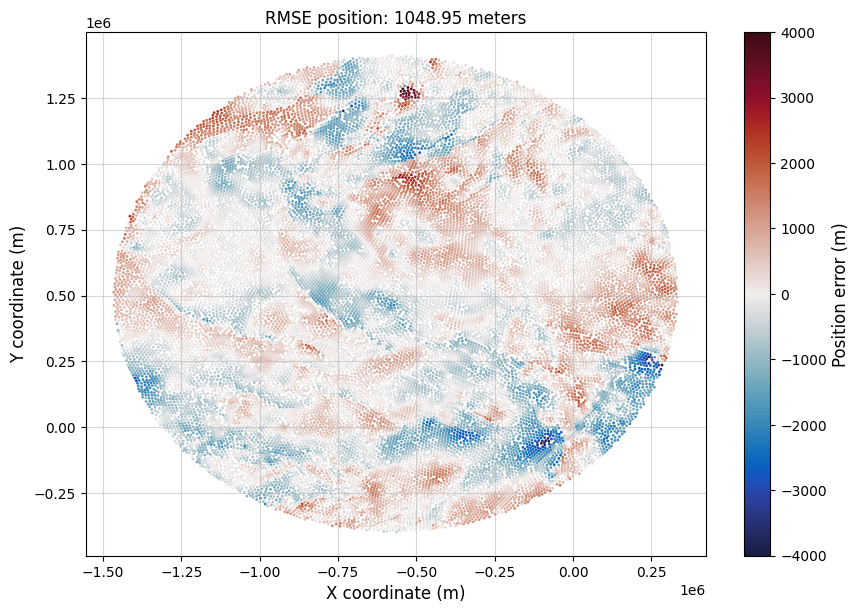

In [72]:

fig, ax = plt.subplots(1,figsize=(10,6.8))
rmse_pos = rmse_pos
norm_rmse = np.sqrt(rmse_pos[0]**2+rmse_pos[1]**2)

im = ax.scatter(data.mesh_pos[:,0][mask],data.mesh_pos[:,1][mask],c=bias_norm[mask],cmap=cm.balance,s=1,vmin=-4000,vmax=4000)
#ax.set_xlim(-2.4e6,1.5e6)
ax.grid(True,alpha=0.5)
ax.set_xlabel('X coordinate (m)', fontsize=12)
ax.set_ylabel('Y coordinate (m)', fontsize=12)
ax.set_title(f"RMSE position: {norm_rmse:.2f} meters")
plt.colorbar(im).set_label("Position error (m)",fontsize=12)


Text(0, 0.5, 'RMSE (m)')

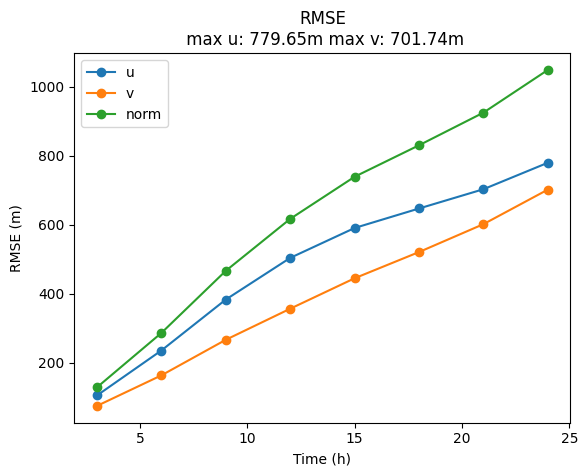

In [73]:
errors = np.stack(errors_position)
#compute norm
errors_norm = np.sqrt(np.sum(errors**2,axis=1))
x = np.arange(lead,len(errors)*lead+lead,lead)
plt.plot(x,errors[:,0],marker='o',label='u')
plt.plot(x,errors[:,1],marker='o',label='v')
plt.plot(x,errors_norm,marker='o',label='norm')
plt.legend()
plt.title(f"RMSE\n max u: {errors[:,0].max():.2f}m max v: {errors[:,1].max():.2f}m")
plt.xlabel("Time (h)")
plt.ylabel("RMSE (m)")

In [9]:
all_errors = np.stack([errors[:,0],errors[:,1],errors_norm],axis=1)
all_errors.shape
#save np array
name = "best_model"
np.save(f"../figures/data/{name}.npy",all_errors)

(8, 3)